# Test 1 Sam Maske: Achtung nicht löschen !!!!!!!!!!


In [10]:
from PIL import Image, ImageOps
import torch
import numpy as np

In [11]:
im_size =[720,720]
mask_path = 'dataset/mini_testdatensatz/segmentation_images/picture_1.png'
img_path = 'dataset/mini_testdatensatz/train/picture_1.png'

In [12]:
def img_patch(img,segmentation=False):
        # Calculate the aspect ratio of the image
        img_ratio = img.width / img.height

        # If the image is wider than it is high
        if img_ratio > 1:
            # Scale the width to the desired size and calculate the height while maintaining the aspect ratio
            new_width = im_size[0]
            new_height = int(new_width / img_ratio)
        # If the image is taller than it is wide
        else:
            # Scale the height to the desired size and calculate the width while maintaining the aspect ratio
            new_height = im_size[1]
            new_width = int(new_height * img_ratio)

        # Resize the image to the calculated size while maintaining the aspect ratio
        img = img.resize((new_width, new_height), resample=Image.BICUBIC)

        # Add black borders to the left and right or top and bottom of the image to make it the desired size
        delta_w = im_size[0] - new_width
        delta_h = im_size[1] - new_height
        pad_width = delta_w // 2
        pad_height = delta_h // 2
        padding = (pad_width, pad_height, delta_w - pad_width, delta_h - pad_height)
        if segmentation:
            img = ImageOps.expand(img, border=padding, fill=(0))
        else:
            img = ImageOps.expand(img, border=padding, fill=(255,255,255))

        # Return the scaled and centered image
        return img

In [13]:
# Achtung, mask und mask tensor sind nur auf Grund der Visualisierung von mask aufkommentiert, im echten Code nicht
def img_segmention2(mask_path):

    mask = Image.open(mask_path).convert('1')
    mask = img_patch(mask,segmentation=True) # problem with the color --> we only need one channel
    mask = np.array(mask)
    mask_tensor = torch.from_numpy(mask)

    return mask_tensor, mask

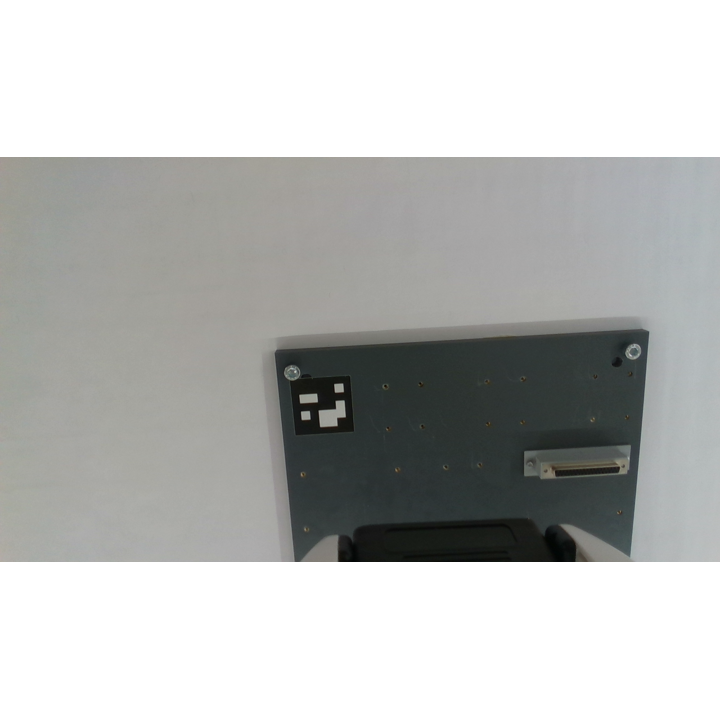

In [14]:
img = Image.open(img_path)
img = img_patch(img)
img = np.array(img)
display(Image.fromarray(img))


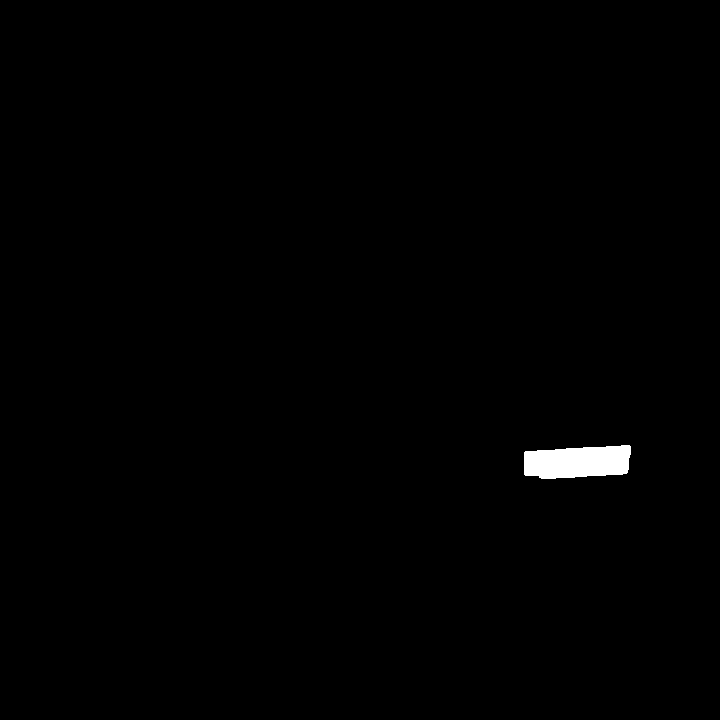

In [15]:
_,mask = img_segmention2(mask_path)
display(Image.fromarray(mask))

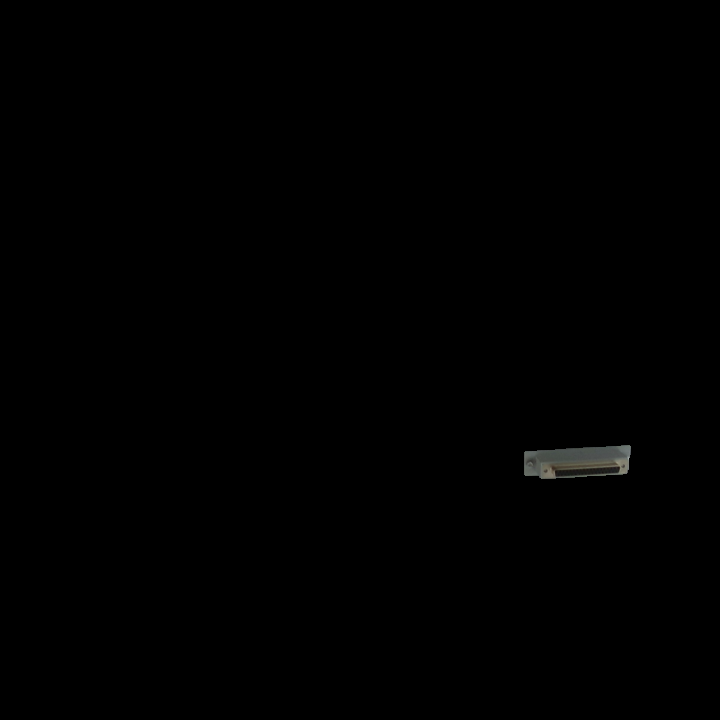

In [16]:
result_array = np.zeros_like(img)
result_array[mask] = img[mask]
result_image = Image.fromarray(result_array)
display(result_image)

# Test 2 Datensatz analysieren 1c

In [ ]:
import numpy as np

# Create a 3D numpy array with shape (height, width, channels) representing an RGB image
img = np.zeros((50, 50, 3)) # Set all values to 0 initially
img[10:20, 20:30, :] = [0, 0, 255] # Set a region of the image to red

# Create a 2D numpy array with shape (height, width) representing a binary mask
mask = np.zeros((50, 50)) # Set all values to 0 initially
mask[10:25, 20:30] = 1 # Set a rectangular region of the mask to 1

# Check that the shapes of the arrays are the same
#assert img.shape[:-1] == mask.shape


# Calculate the mean of the img array for every channel, only using the values of pixels where the corresponding value in the mask array is 1
mean = [[],[],[]]
num_pixels = 0
for channel in range(3):
    values = img[:,:,channel][mask == 1] # Get the values of pixels where the mask is 1 for the current channel
    mean[channel] = np.mean(values) if len(values) > 0 else 0 # Calculate the mean of the values if there are any
    num_pixels += len(values) # Add the number of pixels with valid values to the total


